<a href="https://colab.research.google.com/github/dlhegend/-TS_Academy_Capstone_Project/blob/restore-main/notebooks/douglas_tsa_cp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
df = pd.read_csv('/content/ngx_asi_index_price_data.csv')
df.head()

,date,avr_price
0,2012-01-01,20803.78
1,2012-02-01,20516.42
2,2012-03-01,20918.96
3,2012-04-01,21270.88
4,2012-05-01,22413.52


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       137 non-null    object 
 1   avr_price  137 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


In [4]:
df.head()

,date,avr_price
0,2012-01-01,20803.78
1,2012-02-01,20516.42
2,2012-03-01,20918.96
3,2012-04-01,21270.88
4,2012-05-01,22413.52


In [5]:
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

In [6]:
df.describe()

,avr_price
count,137.000000
mean,34301.277226
std,8428.591014
min,20516.420000
25%,27429.630000
50%,33352.210000
75%,39267.810000
max,55080.760000


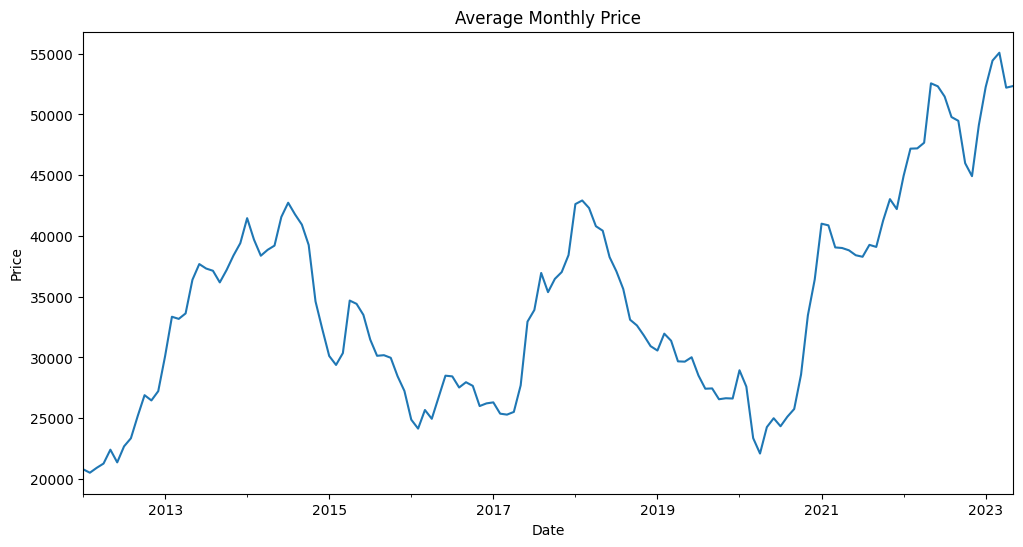

In [7]:
df['avr_price'].plot(title='Average Monthly Price',
                             figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

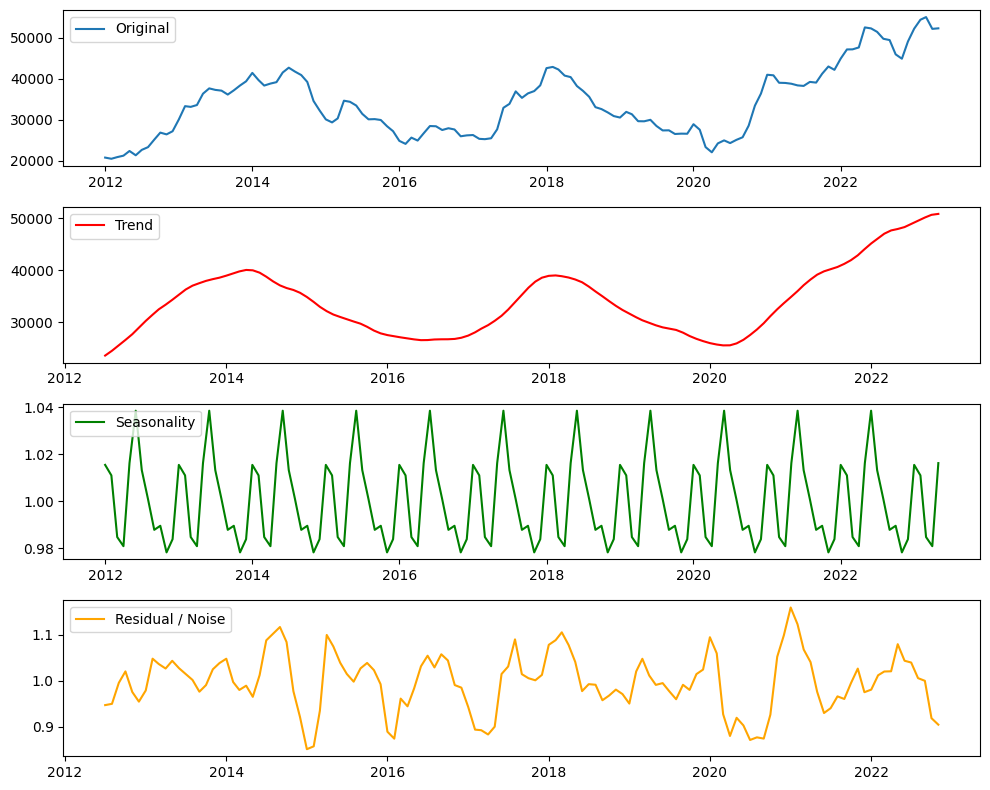

In [8]:
decomposition = seasonal_decompose(df['avr_price'], model='multiplicative', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.figure(figsize=(10,8))

plt.subplot(4,1,1)
plt.plot(df['avr_price'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4,1,2)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='upper left')

plt.subplot(4,1,3)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')

plt.subplot(4,1,4)
plt.plot(residual, label='Residual / Noise', color='orange')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [9]:
adf_result = adfuller(df['avr_price'])

print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
if adf_result[1] < 0.05:
    print("The series is likely stationary")
else:
    print("The series is likely non-stationary")

ADF Statistic: -1.6899
p-value: 0.4363
The series is likely non-stationary


In [10]:
kpss_result = kpss(df['avr_price'], regression='c', nlags='auto')

print(f'KPSS Statistic: {kpss_result[0]:.4f}')
print(f'p-value: {kpss_result[1]:.4f}')

# KPSS test null hypothesis: The series is stationary around a deterministic trend
# If p-value < 0.05, reject the null hypothesis (series is non-stationary)
# If p-value >= 0.05, fail to reject the null hypothesis (series is stationary)
if kpss_result[1] < 0.05:
    print("The series is likely non-stationary (reject H0)")
else:
    print("The series is likely stationary (fail to reject H0)")

KPSS Statistic: 0.6146
p-value: 0.0213
The series is likely non-stationary (reject H0)


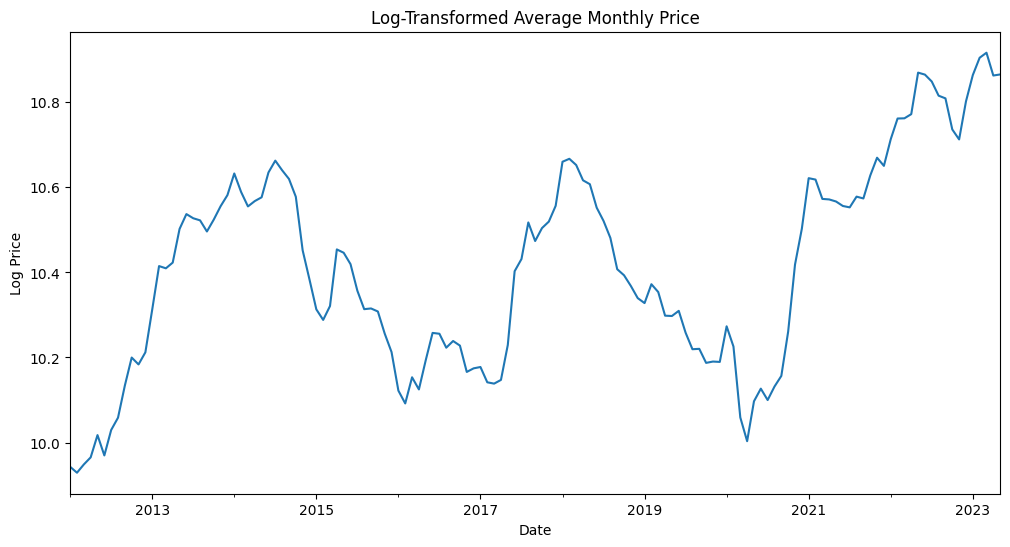

In [11]:
df['log_price'] = np.log(df['avr_price'])

plt.figure(figsize=(12,6))
df['log_price'].plot(title='Log-Transformed Average Monthly Price')
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.show()

In [12]:
def test_stationarity(series):
    print("--- ADF Test Results ---")
    result_adf = adfuller(series)
    print(f'ADF Statistic: {result_adf[0]:.4f}')
    print(f'p-value: {result_adf[1]:.4f}')
    if result_adf[1] < 0.05:
        print("Conclusion: Reject H0, series is likely stationary (no unit root).")
    else:
        print("Conclusion: Fail to reject H0, series is likely non-stationary (has a unit root).")

    print("\n--- KPSS Test Results ---")
    result_kpss = kpss(series, regression='c', nlags='auto')
    print(f'KPSS Statistic: {result_kpss[0]:.4f}')
    print(f'p-value: {result_kpss[1]:.4f}')
    # KPSS test null hypothesis: The series is stationary around a deterministic trend (or mean)
    if result_kpss[1] < 0.05:
        print("Conclusion: Reject H0, series is likely non-stationary (not stationary around a deterministic trend).")
    else:
        print("Conclusion: Fail to reject H0, series is likely stationary (stationary around a deterministic trend).")

    print("\n--- Combined Test Conclusions ---")
    # Interpret combined results
    adf_stationary = result_adf[1] < 0.05
    kpss_stationary = result_kpss[1] >= 0.05

    if adf_stationary and kpss_stationary:
        print("The series is likely stationary (both tests agree).\n")
    elif not adf_stationary and not kpss_stationary:
        print("The series is likely non-stationary (both tests agree).\n")
    elif adf_stationary and not kpss_stationary:
        print("Conflicting results: ADF suggests stationarity, KPSS suggests non-stationarity.\n")
    elif not adf_stationary and kpss_stationary:
        print("Conflicting results: ADF suggests non-stationarity, KPSS suggests stationarity.\n")

In [13]:
test_stationarity(df['log_price'])

--- ADF Test Results ---
ADF Statistic: -2.1087
p-value: 0.2410
Conclusion: Fail to reject H0, series is likely non-stationary (has a unit root).

--- KPSS Test Results ---
KPSS Statistic: 0.5458
p-value: 0.0314
Conclusion: Reject H0, series is likely non-stationary (not stationary around a deterministic trend).

--- Combined Test Conclusions ---
The series is likely non-stationary (both tests agree).



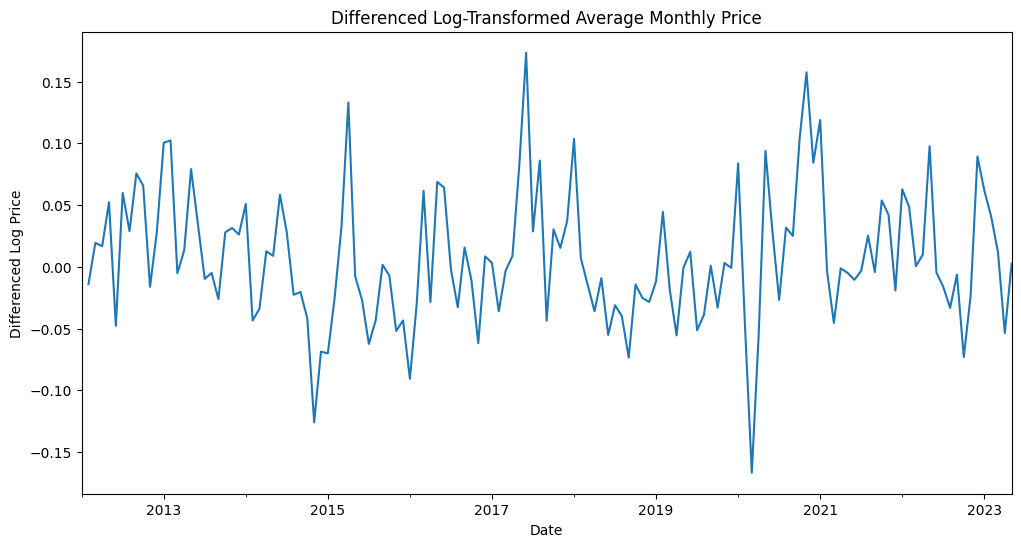

In [14]:
df['diff_log_price'] = df['log_price'].diff()

plt.figure(figsize=(12,6))
df['diff_log_price'].plot(title='Differenced Log-Transformed Average Monthly Price')
plt.xlabel('Date')
plt.ylabel('Differenced Log Price')
plt.show()

In [15]:
test_stationarity(df['diff_log_price'].dropna())

--- ADF Test Results ---
ADF Statistic: -7.6785
p-value: 0.0000
Conclusion: Reject H0, series is likely stationary (no unit root).

--- KPSS Test Results ---
KPSS Statistic: 0.1011
p-value: 0.1000
Conclusion: Fail to reject H0, series is likely stationary (stationary around a deterministic trend).

--- Combined Test Conclusions ---
The series is likely stationary (both tests agree).



/tmp/ipython-input-22964/595602576.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(series, regression='c', nlags='auto')


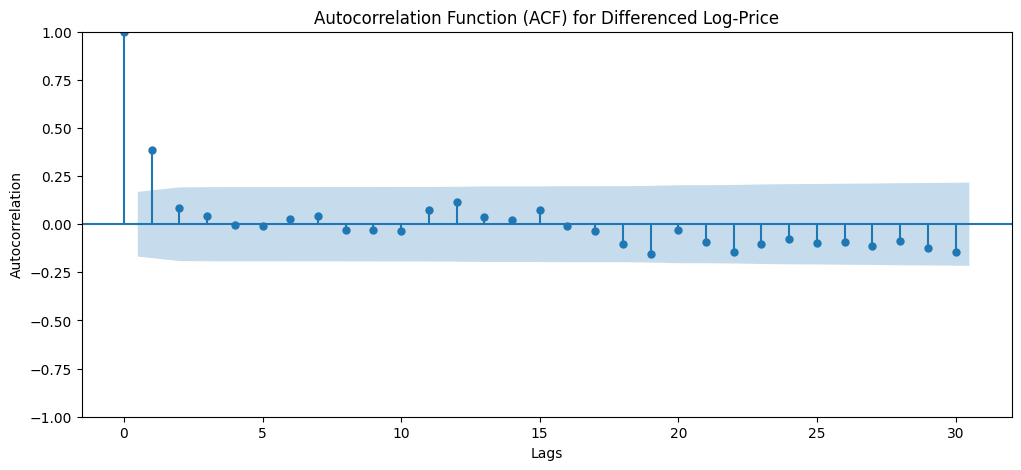

In [16]:
# Create ACF plot
plt.figure(figsize=(12, 5))
plot_acf(df['diff_log_price'].dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for Differenced Log-Price')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

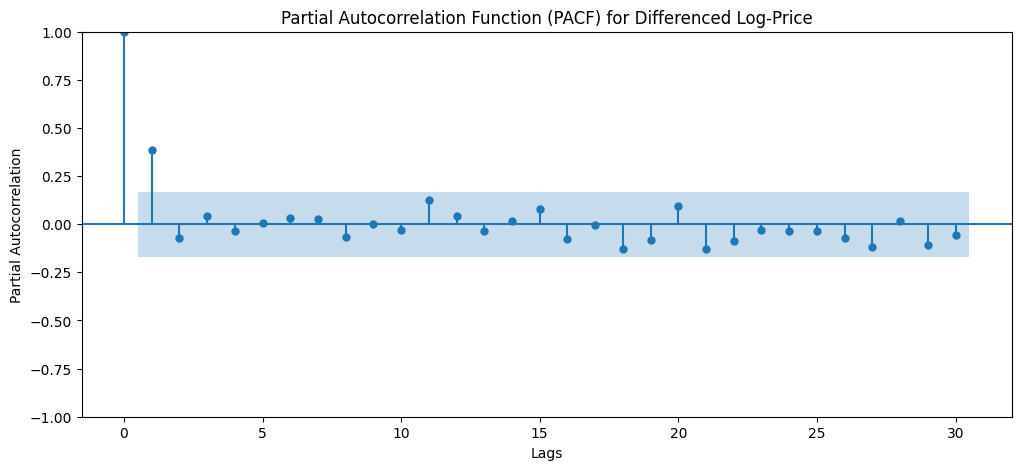

In [17]:
# Create PACF plot
plt.figure(figsize=(12, 5))
plot_pacf(df['diff_log_price'].dropna(), lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) for Differenced Log-Price')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [18]:
train_size = int(len(df) * 0.8)

train = df['log_price'][:train_size]
test = df['log_price'][train_size:]

In [19]:
model = ARIMA(train, order=(1, 1, 1))
fitted_model = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


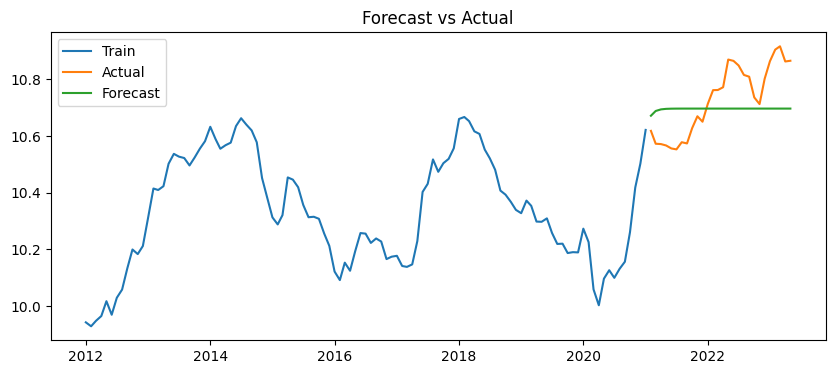

In [20]:
forecast_1 = fitted_model.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train, label='Train')
plt.plot(test, label='Actual')
plt.plot(forecast_1, label='Forecast')
plt.legend()
plt.title("Forecast vs Actual")
plt.show()

In [21]:
def evaluate_model_performance(test, forecast):
  actual = np.exp(test)
  predicted = np.exp(forecast)

  mae = mean_absolute_error(actual, predicted)
  mape = mean_absolute_percentage_error(actual, predicted)
  mse = mean_squared_error(actual, predicted)
  rmse = np.sqrt(mse)

  print(f'Mean Absolute Error (MAE): {mae:.2f}')
  print(f'Mean Absolute Percentage Error (MAPE): {(mape * 100):.2f}%')
  print(f'Mean Squared Error (MSE): {mse:.2f}')
  print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

In [22]:
evaluate_model_performance(test, forecast_1)

Mean Absolute Error (MAE): 5096.01
Mean Absolute Percentage Error (MAPE): 10.87%
Mean Squared Error (MSE): 33477908.01
Root Mean Squared Error (RMSE): 5786.01


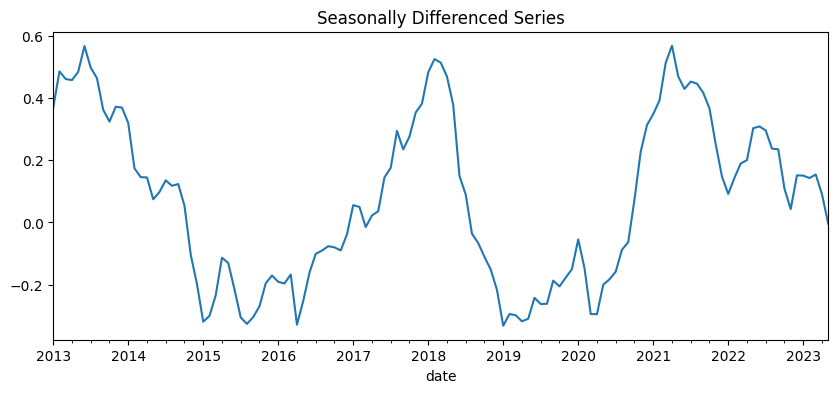

In [23]:
df['Seasonal_Diff'] = df['log_price'] - df['log_price'].shift(12)
df_seasonal = df['Seasonal_Diff'].dropna()

df_seasonal.plot(title="Seasonally Differenced Series", figsize=(10,4))
plt.show()

In [24]:
test_stationarity(df_seasonal)

--- ADF Test Results ---
ADF Statistic: -2.4533
p-value: 0.1273
Conclusion: Fail to reject H0, series is likely non-stationary (has a unit root).

--- KPSS Test Results ---
KPSS Statistic: 0.1605
p-value: 0.1000
Conclusion: Fail to reject H0, series is likely stationary (stationary around a deterministic trend).

--- Combined Test Conclusions ---
Conflicting results: ADF suggests non-stationarity, KPSS suggests stationarity.



/tmp/ipython-input-22964/595602576.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(series, regression='c', nlags='auto')
